# Testing decoder functionality

In [1]:
### BASE IMPORTS ###

import numpy as np
import matplotlib.pyplot as plt
import torch

import neural_decoding.decoders
import neural_decoding.decoders.linear_decoders

### Ridge Regression Model Tests

In [3]:

fake_x = np.linspace(-np.pi, np.pi, 201)[:,np.newaxis]
fake_y = fake_x + np.random.rand(201,1)

rr = neural_decoding.decoders.linear_decoders.ridge_regression(4,1,{'theta':0, 'lbda':0, 'intercept':True})

rr.train(fake_x, fake_y)
yhat = rr.forward(fake_x)


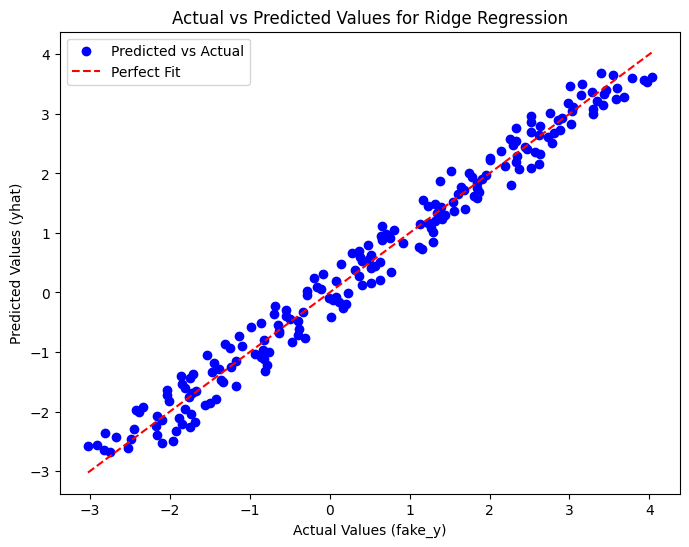

In [5]:
# Plot the actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(fake_y, yhat, color='blue', label='Predicted vs Actual')

# Add a 45-degree reference line for perfect prediction
plt.plot([fake_y.min(), fake_y.max()], [fake_y.min(), fake_y.max()], color='red', linestyle='--', label='Perfect Fit')

# Add labels and title
plt.xlabel('Actual Values (fake_y)')
plt.ylabel('Predicted Values (yhat)')
plt.title('Actual vs Predicted Values for Ridge Regression')
plt.legend()

# Display the plot
plt.show()

### Kalman Filter Model Tests

100%|██████████| 99/99 [00:00<00:00, 30491.71it/s]


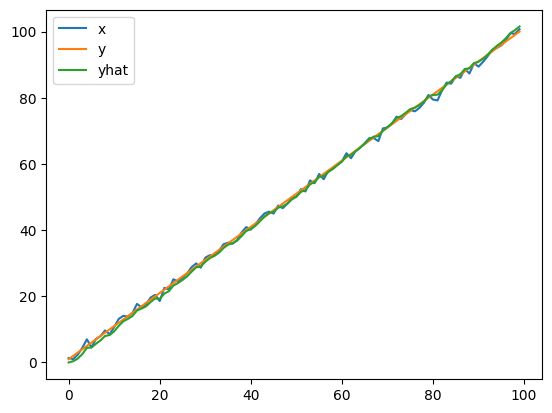

Mean Squared Error: 0.6561717391014099


In [7]:
# Set up Data
N = 100

# linear relationship (simulated data)
X = torch.arange(N, dtype=torch.float32).reshape((N, 1)) + torch.randn(N, 1) + 1
y = torch.arange(N, dtype=torch.float32).reshape((N, 1)) + 1


model_config = {
    'append_ones_y': False,
    "device": "cpu",
    "return_tensor":True
}

# Instantiate Train Model
model = neural_decoding.decoders.linear_decoders.KalmanFilter(0,0,model_config)
model.train(X, y)

# Make Prediction
yhat = model.forward(X)


# Plot (yhat should follow y, it should infer hidden state from noisy x)
plt.plot(X, label='x')
plt.plot(y, label='y')
plt.plot(yhat, label='yhat')
plt.legend()
plt.show()


# MSE calculation
mse = torch.mean((yhat - y) ** 2)
print(f"Mean Squared Error: {mse}")

### LSTM Model Tests

In [2]:
### IMPORTS AND PATH STUFF ###

import sys
import os

# Adding my main directory to the Python path. Your set-up may be different.
sys.path.append(os.path.abspath('..'))

import pandas as pd
import random
import TrainingUtils

from torch.utils.data import DataLoader
from neural_decoding.decoders import BASE_NN_decoder
from neural_decoding.decoders import nonlinear_decoders


In [3]:
### SET SEEDS ###

# Set Random Seeds
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# If using CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)  # For multi-GPU setups

In [4]:
### READ IN AND SET-UP DATA ###

df = pd.read_csv("../general_testing_data_and_scripts/2022-09-21_RD_timeseries.csv") # NOTE: your path will be different

# Select input features (neural data)
input_features = [col for col in df.columns if col.startswith('sbp_channel_')]

# Select output features (position and velocity)
output_features = ['index_position', 'mrp_position', 'index_velocity', 'mrp_velocity']

# set-up to format dataset
X_neural = df[input_features].values
Y_fings = df[output_features].values

# get formatted dataset
dataset = TrainingUtils.FingerDataset(
    device="cpu",
    X_neural=X_neural,
    Y_fings=Y_fings,
    predtype='pv',  # predict both position and velocity
    numfingers=2,   # assuming you have 2 fingers (index and mrp)
    numdelays=3,    # adjust as needed
    positioninput=True,  # include previous position as input
    last_timestep_recent=True,  # for RNNs
)

# split up train and validation datasets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# get train and validation data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
data_loader = {
    "loader_train": train_loader,
    "loader_val": val_loader
}

In [5]:
### CREATE MODEL ###

# Define model parameters
input_size = dataset.chan_states[0].shape[1]  # Number of input features
num_outputs = dataset.chan_states[1].shape[1]  # Number of output features
model_params = {
    "hidden_size": 128,
    "num_layers": 2,
    "rnn_type": "lstm",
    "drop_prob": 0.2,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

# Initialize the model
model = nonlinear_decoders.LSTM(input_size, num_outputs, model_params)

# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [6]:
### TRAIN MODEL ###

# Define training parameters
training_params = {
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "print_results" : True,
    "epochs": 100
}

# Train the model
val_loss, loss_history_tuple = model.train_model(data_loader, criterion, optimizer, training_params)

Epoch [0/99], iter 209 Loss: 0.0049, Validation Loss: 0.0038
Epoch [10/99], iter 2299 Loss: 0.0014, Validation Loss: 0.0009
Epoch [20/99], iter 4389 Loss: 0.0006, Validation Loss: 0.0006
Epoch [30/99], iter 6479 Loss: 0.0005, Validation Loss: 0.0006
Epoch [40/99], iter 8569 Loss: 0.0003, Validation Loss: 0.0006
Epoch [50/99], iter 10659 Loss: 0.0003, Validation Loss: 0.0005
Epoch [60/99], iter 12749 Loss: 0.0002, Validation Loss: 0.0004
Epoch [70/99], iter 14839 Loss: 0.0003, Validation Loss: 0.0004
Epoch [80/99], iter 16929 Loss: 0.0002, Validation Loss: 0.0004
Epoch [90/99], iter 19019 Loss: 0.0002, Validation Loss: 0.0004
Epoch [99/99], iter 20900 Loss: 0.0002, Validation Loss: 0.0004
*** final epoch is done ***


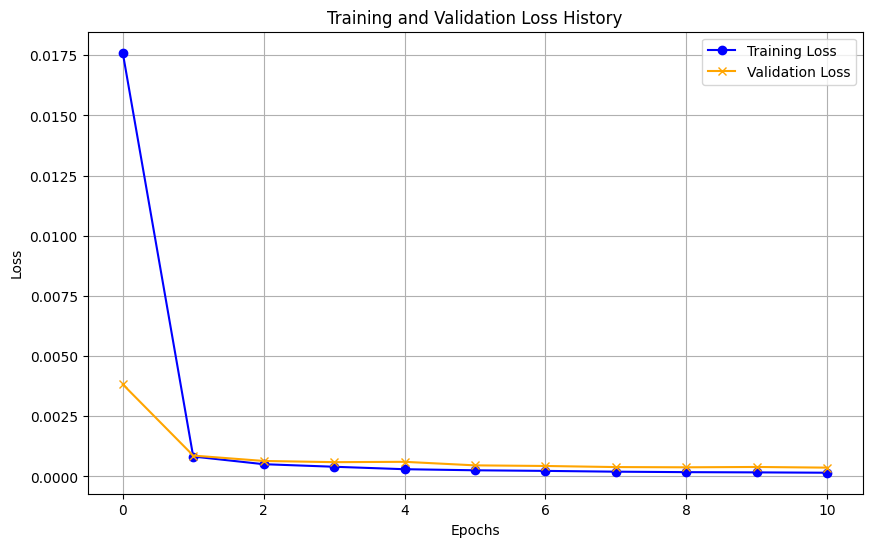

In [7]:
### PLOT LOSS TRAINING DATA ###

# Create a new figure
plt.figure(figsize=(10, 6))

# Plotting training and validation loss
plt.plot(loss_history_tuple[0], label='Training Loss', color='blue', marker='o')
plt.plot(loss_history_tuple[1], label='Validation Loss', color='orange', marker='x')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss History')
plt.legend()

# Show grid
plt.grid()

# Display the plot
plt.show()

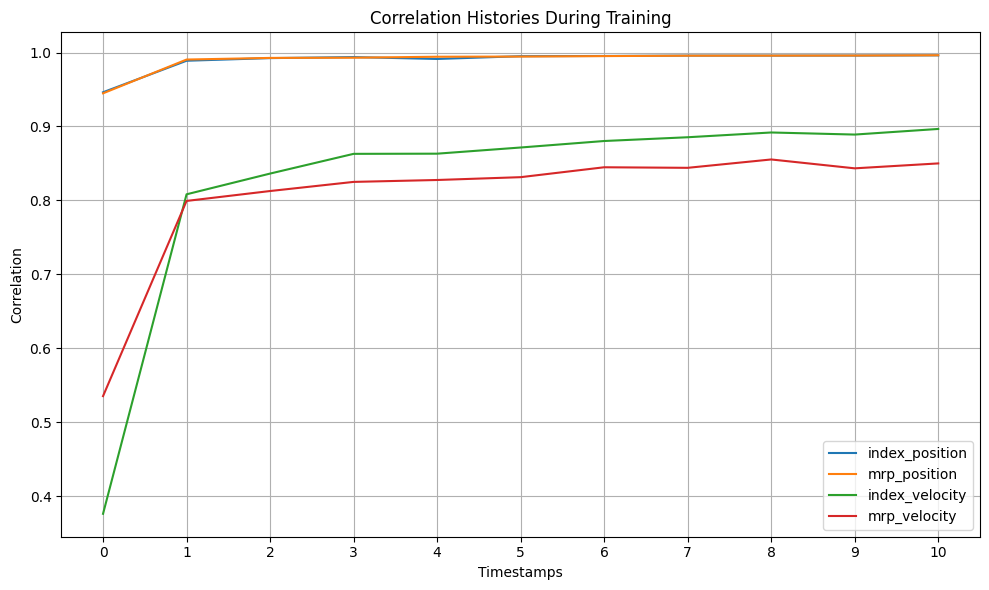

In [8]:
### PLOT CORRELATION TRAINING DATA ###

# Create the plot
plt.figure(figsize=(10, 6))
corr_history = np.array(loss_history_tuple[2])

# Plot each feature's correlation over the timestamps
for i, feature in enumerate(output_features):
    plt.plot(corr_history[:, i], label=feature)

# Customize the plot
plt.title('Correlation Histories During Training')
plt.xlabel('Timestamps')
plt.ylabel('Correlation')
plt.xticks(np.arange(len(corr_history)))  # Set x-ticks to the number of timestamps
plt.grid()
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()